### PROJET N° 7 - Implémenter un modèle de scoring

Auteur : Florian FOLLAIN
Date : Fevrier 2024

#### Reprend le Notebook P7_SCORING codé avec la librairie mlflows afin de pouvoir suivre les résultats sur mlflow UI

In [30]:
import pandas as pd
import psutil
import os
from collections import Counter

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

import mlflow
import mlflow.sklearn

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

#Scikit-Learn
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer

# Balancing data
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler


import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)
#from sklearn.ensemble import HistGradientBoostingRegressor

In [8]:
def print_memory_usage():
    pid = os.getpid()
    py = psutil.Process(pid)
    memory_use = py.memory_info()[0]/(2.**30)
    print(f'mémoire RAM utilisée: {memory_use:.2f} GB')

In [9]:
train_df = pd.read_csv(r'C:\P7\data_api\train_df.csv')
test_df = pd.read_csv(r'C:\P7\data_api\test_df.csv')

In [10]:
test_api = test_df.sample(n=1000, replace=True)
test_api.to_csv('test_api.csv')

In [11]:
train_df.head()

,Unnamed: 0,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cashloans,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Groupofpeople,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,NAME_TYPE_SUITE_Spousepartner,NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercialassociate,NAME_INCOME_TYPE_Maternityleave,NAME_INCOME_TYPE_Stateservant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academicdegree,NAME_EDUCATION_TYPE_Highereducation,NAME_EDUCATION_TYPE_Incompletehigher,NAME_EDUCATION_TYPE_Lowersecondary,NAME_EDUCATION_TYPE_Secondarysecondaryspecial,NAME_FAMILY_STATUS_Civilmarriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Singlenotmarried,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Coopapartment,NAME_HOUSING_TYPE_Houseapartment,NAME_HOUSING_TYPE_Municipalapartment,NAME_HOUSING_TYPE_Officeapartment,NAME_HOUSING_TYPE_Rentedapartment,NAME_HOUSING_TYPE_Withparents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaningstaff,OCCUPATION_TYPE_Cookingstaff,OCCUPATION_TYPE_Corestaff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HRstaff,OCCUPATION_TYPE_Highskilltechstaff,OCCUPATION_TYPE_ITstaff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_LowskillLaborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicinestaff,OCCUPATION_TYPE_Privateservicestaff,OCCUPATION_TYPE_Realtyagents,OCCUPATION_TYPE_Salesstaff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Securitystaff,OCCUPATION_TYPE_Waitersbarmenstaff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_BusinessEntityType1,ORGANIZATION_TYPE_BusinessEntityType2,ORGANIZATION_TYPE_BusinessEntityType3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industrytype1,ORGANIZATION_TYPE_Industrytype10,ORGANIZATION_TYPE_Industrytype11,ORGANIZATION_TYPE_Industrytype12,ORGANIZATION_TYPE_Industrytype13,ORGANIZATION_TYPE_Industrytype2

In [12]:
#Création score métier 
def custom_metric(y_true, y_pred):
    """Fonction qui extraie de la matrice de confusion les
    valeurs des 4 mesures et retourne un calcul sur base
    d'une pondération de FP et FN"""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel().tolist()
    score=(10*fn + fp)/len(y_true)
    return score
score_metier=make_scorer(custom_metric, greater_is_better=False)

scoring = {"AUC": "roc_auc", "score_metier": score_metier}

In [13]:
TRAIN_SIZE = 0.8
RANDOM_STATE = 42
X = train_df.drop('TARGET', axis=1)
y = train_df['TARGET']
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_SIZE, random_state=RANDOM_STATE)

In [14]:
strat_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [15]:
y_train_counter = Counter(y_train)
print("Training target stats", y_train_counter)
print("Testing target stats", Counter(y_test))
#ratio
print("Ratio is 1:{:.0f}".format(y_train_counter[0] / y_train_counter[1]))

Training target stats Counter({0.0: 226201, 1.0: 19804})
Testing target stats Counter({0.0: 56481, 1.0: 5021})
Ratio is 1:11


In [16]:
# Define oversampling and undersampling
over = SMOTE(sampling_strategy=0.5) # oversample to 1:2 ratio 
under = RandomUnderSampler(sampling_strategy=1) # undersample to 1:1 ratio

# Define pipeline
steps = [('over', over), ('under', under)]
# steps = [('over', over)]
pipeline = Pipeline(steps=steps)

# Transform the dataset
x_res, y_res = pipeline.fit_resample(x_train, y_train)

print("Training target statistics:", Counter(y_res))
print("Testing target statistics:", Counter(y_test))

Training target statistics: Counter({0.0: 113100, 1.0: 113100})
Testing target statistics: Counter({0.0: 56481, 1.0: 5021})


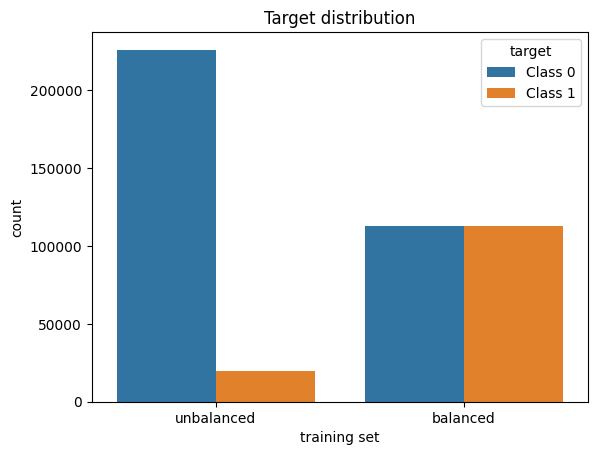

In [17]:
# Display barplot of distribution
class_distr_df = pd.DataFrame({'training set': ['unbalanced', 'unbalanced', 'balanced', 'balanced'],
                               'target': ['Class 0', 'Class 1', 'Class 0', 'Class 1'],
                               'count': [y_train_counter[0], y_train_counter[1], Counter(y_res)[0], Counter(y_res)[1]]})

# Display barplot
sns.barplot(class_distr_df, x='training set', y='count', hue='target')
plt.title("Target distribution")
plt.show()

In [18]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
def plot_sklearn_roc_curve(y_real, y_pred):
    fpr, tpr, _ = roc_curve(y_real, y_pred)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    roc_display.figure_.set_size_inches(5,5)
    plt.plot([0, 1], [0, 1], color = 'g')

In [19]:
# Configuration du modèle pour DummyClassifier
model_config_dummy = {
    'model': Pipeline([
         ('scaler', StandardScaler()),
         ('dummy', DummyClassifier())
    ]),
    'params': {
        'dummy__strategy': ['most_frequent', 'stratified']
    }
}

def evaluate_model_dummy(x_res, y_res):
    mlflow.set_experiment("Dummy_Classifier_Evaluation")

    with mlflow.start_run(run_name="Dummy Classifier"):
        gs = GridSearchCV(model_config_dummy['model'], model_config_dummy['params'], cv=5, scoring=scoring, refit="AUC", verbose=1)
        gs.fit(x_res, y_res)

        # Log parameters and metrics
        mlflow.log_params(gs.best_params_)
        mlflow.log_metric("best_score_auc", gs.best_score_)
        # Assurez-vous d'avoir défini le calcul de votre score personnalisé 'best_score_metier' correctement avant d'utiliser cette ligne
        mlflow.log_metric("best_score_metier", gs.cv_results_['mean_test_score_metier'][gs.best_index_])
        
        # Save and log model
        mlflow.sklearn.log_model(gs.best_estimator_, "Dummy")

        # Plot and log confusion matrix
        y_pred = gs.predict(x_res)
        cm = confusion_matrix(y_res, y_pred)
        plt.figure(figsize=(5,5))
        sns.heatmap(cm, annot=True, fmt="d")
        plt.title("Confusion Matrix: Dummy Classifier")
        plt.savefig("confusion_matrix_dummy_classifier.png")
        mlflow.log_artifact("confusion_matrix_dummy_classifier.png")
        
        plt.close('all')


In [20]:
#evaluate_model_dummy(x_res, y_res)

Traceback (most recent call last):
  File "c:\Users\flori\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 302, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\flori\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 395, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\flori\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1303, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\flori\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 12

Fitting 5 folds for each of 2 candidates, totalling 10 fits


c:\Users\flori\AppData\Local\Programs\Python\Python311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [27]:
# Configuration du modèle pour LogistiqueRegression
model_config_lr = {
    'model': Pipeline([
         ('scaler', StandardScaler()),
         ('Logreg', LogisticRegression(solver='lbfgs', class_weight='balanced', max_iter=10000))
    ]),
    'params': {
        'Logreg__penalty': ['l2'],
        'Logreg__C': [100, 1000]
    }
}

def evaluate_model_LR(x_res, y_res):
    mlflow.set_experiment("Logistic_Regression_Evaluation")

    with mlflow.start_run(run_name="Logistic Regression"):
        gs = GridSearchCV(model_config_lr['model'], model_config_lr['params'], cv=5, scoring=scoring, refit="AUC", return_train_score=True, verbose=1)
        gs.fit(x_res, y_res)

        # Log parameters, metrics, and model
        mlflow.log_params(gs.best_params_)
        mlflow.log_metric("best_score_auc", gs.best_score_)
        mlflow.log_metric("best_score_metier", gs.cv_results_['mean_test_score_metier'][gs.best_index_])
        
        # Save and log model
        mlflow.sklearn.log_model(gs.best_estimator_, "LogReg")

        # Plot and log confusion matrix
        y_pred = gs.predict(x_res)
        cm = confusion_matrix(y_res, y_pred)
        plt.figure(figsize=(5,5))
        sns.heatmap(cm, annot=True, fmt="d")
        plt.title("Confusion Matrix: Logistic Regression")
        plt.savefig("confusion_matrix_logistic_regression.png")
        mlflow.log_artifact("confusion_matrix_logistic_regression.png")
        
        plt.close('all')

In [28]:
evaluate_model_LR(x_res, y_res)

Traceback (most recent call last):
  File "c:\Users\flori\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 302, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\flori\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 395, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\flori\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1303, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\flori\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 12

Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [24]:
# Configuration du modèle pour DecisionTreeClassifier
model_config_dt = {
    'model': Pipeline([
         ('scaler', StandardScaler()),
         ('DecisionTree', DecisionTreeClassifier())
    ]),
    'params': {
        'DecisionTree__criterion': ["gini", "entropy"],
        'DecisionTree__min_samples_leaf': list(range(5, 7, 1)),
        "DecisionTree__max_depth": list(range(2, 4, 1))
    }
}

def evaluate_model_DT(x_res, y_res):
    mlflow.set_experiment("Decision_Tree_Evaluation")

    with mlflow.start_run(run_name="Decision Tree"):
        gs = GridSearchCV(model_config_dt['model'], model_config_dt['params'], cv=5, scoring=scoring, refit="AUC", return_train_score=True, verbose=1)
        gs.fit(x_res, y_res)

        # Log parameters and metrics
        mlflow.log_params(gs.best_params_)
        mlflow.log_metric("best_score_auc", gs.best_score_)
        mlflow.log_metric("best_score_metier", gs.cv_results_['mean_test_score_metier'][gs.best_index_])
        
        # Save and log model
        mlflow.sklearn.log_model(gs.best_estimator_, "DecisionTree")

        # Plot and log confusion matrix
        y_pred = gs.predict(x_res)
        cm = confusion_matrix(y_res, y_pred)
        plt.figure(figsize=(5,5))
        sns.heatmap(cm, annot=True, fmt="d")
        plt.title("Confusion Matrix: Decision Tree")
        plt.savefig("confusion_matrix_decision_tree.png")
        mlflow.log_artifact("confusion_matrix_decision_tree.png")
        
        plt.close('all')


In [ ]:
#evaluate_model_DT(x_res, y_res)

2024/02/27 14:13:59 INFO mlflow.tracking.fluent: Experiment with name 'Decision_Tree_Evaluation' does not exist. Creating a new experiment.


Fitting 5 folds for each of 8 candidates, totalling 40 fits


c:\Users\flori\AppData\Local\Programs\Python\Python311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [25]:
# Configuration du modèle pour LGBMClassifier
model_config_lgbm = {
    'model': Pipeline([
         ('scaler', StandardScaler()),
         ('LGBMC', LGBMClassifier())
    ]),
    'params': {
        'LGBMC__subsample': [0.5, 0.75],
        'LGBMC__reg_lambda': [1, 2],
        'LGBMC__colsample_bytree': [0.97, 0.99]
    }
}

def evaluate_model_LGBM(x_res, y_res):
    mlflow.set_experiment("LGBM_Classifier_Evaluation")

    with mlflow.start_run(run_name="LGBM Classifier"):
        gs = GridSearchCV(model_config_lgbm['model'], model_config_lgbm['params'], cv=5, scoring=scoring, refit="AUC", return_train_score=True, verbose=1)
        gs.fit(x_res, y_res)

        # Log parameters and metrics
        mlflow.log_params(gs.best_params_)
        mlflow.log_metric("best_score_auc", gs.best_score_)
        # Assurez-vous d'avoir défini le calcul de votre score personnalisé 'best_score_metier' correctement avant d'utiliser cette ligne
        mlflow.log_metric("best_score_metier", gs.cv_results_['mean_test_score_metier'][gs.best_index_])
        
        # Save and log model
        mlflow.sklearn.log_model(gs.best_estimator_, "LGBMClassifier")

        # Plot and log confusion matrix
        y_pred = gs.predict(x_res)
        cm = confusion_matrix(y_res, y_pred)
        plt.figure(figsize=(5,5))
        sns.heatmap(cm, annot=True, fmt="d")
        plt.title("Confusion Matrix: LGBM Classifier")
        plt.savefig("confusion_matrix_lgbm_classifier.png")
        mlflow.log_artifact("confusion_matrix_lgbm_classifier.png")
        
        plt.close('all')

In [26]:
evaluate_model_LGBM(x_res, y_res)

Traceback (most recent call last):
  File "c:\Users\flori\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 302, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\flori\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 395, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\flori\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1303, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\flori\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 12

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [31]:
# Configuration du modèle pour CatBoostClassifier
model_config_catboost = {
    'model': Pipeline([
         ('scaler', StandardScaler()),
         ('CatBoost', CatBoostClassifier(logging_level='Silent'))
    ]),
    'params': {
        'CatBoost__max_depth': [3, 4, 6],
        'CatBoost__n_estimators': [100, 200, 300]
    }
}

def evaluate_model_CatBoost(x_res, y_res):
    mlflow.set_experiment("CatBoost_Classifier_Evaluation")

    with mlflow.start_run(run_name="CatBoost Classifier"):
        gs = GridSearchCV(model_config_catboost['model'], model_config_catboost['params'], cv=5, scoring=scoring, refit="AUC", return_train_score=True, verbose=1)
        gs.fit(x_res, y_res)

        # Log parameters and metrics
        mlflow.log_params(gs.best_params_)
        mlflow.log_metric("best_score_auc", gs.best_score_)
        # Assurez-vous d'avoir défini le calcul de votre score personnalisé 'best_score_metier' correctement avant d'utiliser cette ligne
        mlflow.log_metric("best_score_metier", gs.cv_results_['mean_test_score_metier'][gs.best_index_])
        
        # Save and log model
        mlflow.sklearn.log_model(gs.best_estimator_, "CatBoostClassifier")

        # Plot and log confusion matrix
        y_pred = gs.predict(x_res)
        cm = confusion_matrix(y_res, y_pred)
        plt.figure(figsize=(5,5))
        sns.heatmap(cm, annot=True, fmt="d")
        plt.title("Confusion Matrix: CatBoost Classifier")
        plt.savefig("confusion_matrix_catboost_classifier.png")
        mlflow.log_artifact("confusion_matrix_catboost_classifier.png")
        
        plt.close('all')

In [32]:
evaluate_model_CatBoost(x_res, y_res)

Traceback (most recent call last):
  File "c:\Users\flori\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 302, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\flori\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 395, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\flori\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1303, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\flori\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 12

Fitting 5 folds for each of 9 candidates, totalling 45 fits
